Time series with SARIMAX
    
Known monthly accidental deaths in the United States from January 1973 to December 1978,
it is necessary to build a forecast for 2 years with the chart at the end.

Работа с временными рядами.
    Известно ежемесячное число смертей в результате несчастного случая в США с января 1973 по декабрь 1978, 
необходимо построить прогноз на следующие 2 года. Ожидаю в конце уидеть график.
При выполнении работ напишите введение и вывод.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [2]:
dataset = pd.read_csv('accidental-deaths-in-usa-monthly.csv', index_col=['Month'], parse_dates=['Month'])
plotly_df(dataset, title = "Accidental deaths in USA: monthly, 1973 - 1978")

In [3]:
dataset.describe()

,"Accidental deaths in USA: monthly, 1973 - 1978"
count,72.000000
mean,8787.736111
std,958.338013
min,6892.000000
25%,8089.000000
50%,8728.500000
75%,9323.250000
max,11317.000000


In [ ]:
dataset

In [12]:
dataset = dataset.rename(columns={'Accidental deaths in USA: monthly, 1973 - 1978': 'AccidentalDeath'})

In [14]:
train = dataset[:-24]
test = dataset[-24:]

In [16]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(dataset.AccidentalDeath, 12) # look at the forecast based on the last observed year (12 months)


8796.75

Unfortunately, such a long-term forecast cannot be made; in order to obtain a prediction one step ahead, the previous value must be an actually observed value. But the moving average has another use - smoothing the original series to identify trends, pandas has a ready-made implementation - [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). The more we set the width of the interval, the smoother the trend will be. In case the data is very noisy, which is especially common, for example, in financial indicators, such a procedure can help to see common patterns.

К сожалению, такой прогноз долгосрочным сделать не удастся, для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение - сглаживание исходного ряда для выявления трендов, в пандасе есть готовая реализация - [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). Чем больше зададим ширину интервала - тем более сглаженным окажется тренд. В случае, если данные сильно зашумлены, что особенно часто встречается, например, в финансовых показателях, такая процедура может помочь увидеть общие паттерны.

In [18]:
def plotMovingAverage(series, n):
    
    """
    series - dataframe with timeseries
    n - rolling window size 
    
    """
    
    rolling_mean = series.rolling(window=n).mean()
    
    plt.figure(figsize=(30,10))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [19]:
rolling_mean = dataset.rolling(window=7).mean()

In [20]:
rolling_mean[:12]

,AccidentalDeath
Month,
1973-01-01,NaN
1973-02-01,NaN
1973-03-01,NaN
1973-04-01,NaN
1973-05-01,NaN
1973-06-01,NaN
1973-07-01,9619.714286
1973-08-01,9867.857143
1973-09-01,10097.428571


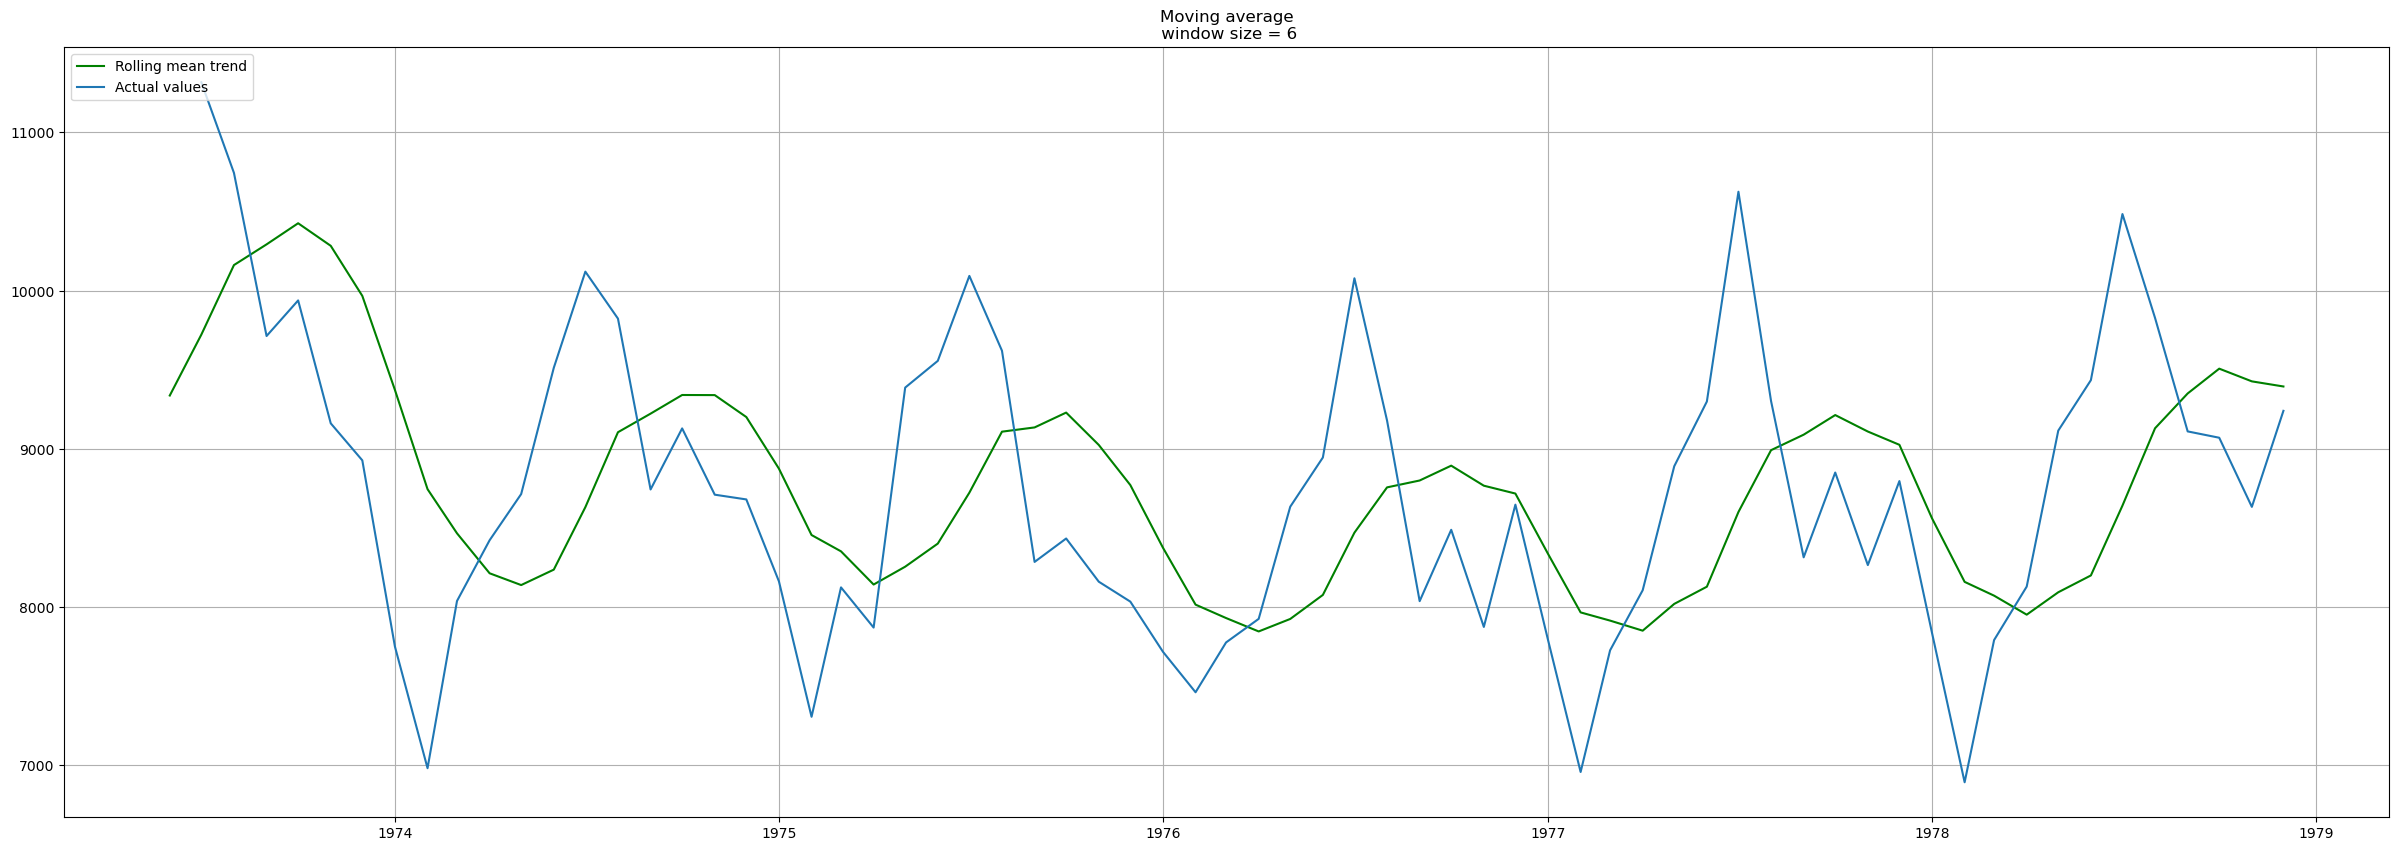

In [21]:
plotMovingAverage(dataset, 6) # smooth for six months (сглаживаем по полгода)


For our series, the trends are already quite obvious, but if we smooth out for half a year, the dynamics of the next cm become better visible. since the beginning of summer. Summer is the peak of death.

Для нашего ряда тренды и так вполне очевидны, но если сгладить по полгода, становиться лучше видна динамика сл.см. с начала лета. На лето приходит пик смертей

In [29]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1]<0.05:
        print('Time Series is stationary')
    else: 
        print('Time Series is not stationary')

In [30]:
check_stationarity(dataset.diff(12).diff(1).dropna())

ADF Statistic: -7.937464
p-value: 0.000000
Time Series is stationary


we have the following parameters already found:

m = 12,
d = 1,
D = 1

Let's now find the other components.

In [43]:
def plot_acf_pacf_graphs(series):
    fig, ax = plt.subplots(2,1)
    fig = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(series, lags=25, ax=ax[1])
    plt.tight_layout()
    plt.show()

In [44]:
diff_ds = dataset.diff(12).diff(1).dropna()

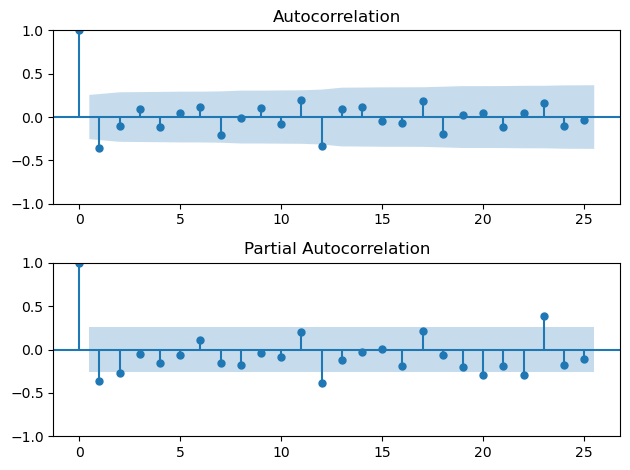

In [45]:
plot_acf_pacf_graphs(diff_ds)

После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций резко падают. В нашем случае параметры P и Q будут равны 0 (это видно если посмотреть на ACF и PACF на указанных выше лагах).

We look at the multiples of the seasonal period to detect the seasonal components and the low rank lags for the ARIMA components.

ACF: we can see there is low rank lags. Let's set q = 1.

ACF: it seems that the seasonal component here is 0. Since the lag 12 is null and the 24th is slightly significant. We can ignore this or we can set the component to 1. Let's start with Q = 0.
 
PACF: We have some signifcant low rank lags. Let's set p = 1.

 PACF: There might be a confusion about lag 12 we can consider it as 0 or 1. Let's start with P=0.

In [34]:
def sarimax_modeling(series, params, s_params):
    model = sm.tsa.statespace.SARIMAX(series, order=params, 
                                      seasonal_order=s_params).fit(max_iter=50, method='powell')
    print('SARIMAX{}x{} - AIC:{}'.format(params, s_params, model.aic))
    print(model.summary())
    

In [37]:
def sarimax_walk_forward_forecast(series, params, s_params, steps=5):
    history = series.copy()
    predictions = [history.iloc[-1]]
    predictions_ci_min = [history.iloc[-1]]
    predictions_ci_max = [history.iloc[-1]]
    predictions_ci_index = [history.index[-1]]
    for t in range(steps):
        model = sm.tsa.statespace.SARIMAX(history, order=params, seasonal_order=s_params)
        model_fit = model.fit(max_iter=50, method='powell', disp=False)
        predictions.append(model_fit.get_forecast().predicted_mean[0])
        predictions_ci_min.append(model_fit.get_forecast().conf_int().values[0,0])
        predictions_ci_max.append(model_fit.get_forecast().conf_int().values[0,1])
        predictions_ci_index.append(model_fit.get_forecast().conf_int().index.tolist()[0])
        history = history.append(model_fit.get_forecast().predicted_mean)
    plt.figure(figsize=(14, 4))
    plt.plot(predictions_ci_index, predictions, label='Walk-Forward ahead Forecast', alpha=.7, color='red')
    plt.plot(series, label='observed', color='blue')
    plt.fill_between(predictions_ci_index, predictions_ci_min, predictions_ci_max, color='k', alpha=.2)
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

/Users/Ulyana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/Ulyana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/Ulyana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/Ulyana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/Ulyana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/Ulyana/opt/anaconda3/lib/python3.9/site-packages

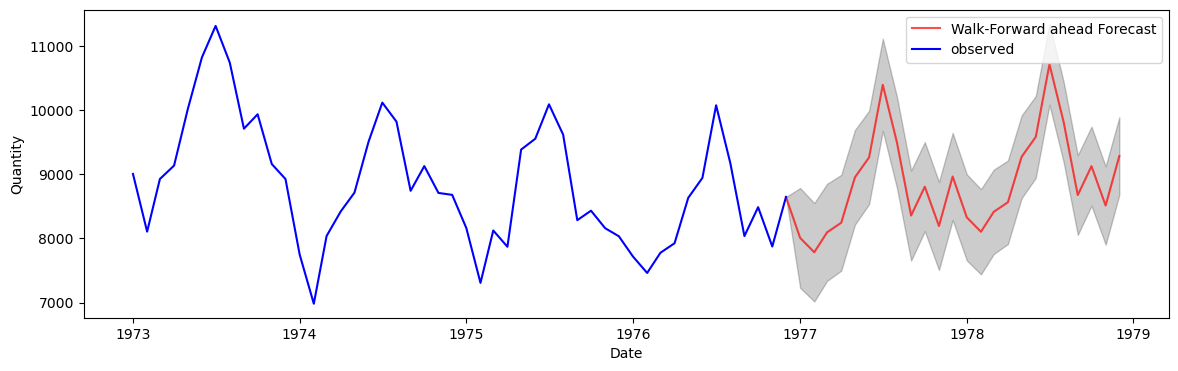

In [46]:
sarimax_walk_forward_forecast(train['AccidentalDeath'],params=(1,1,1), s_params=(0,1,0,12), steps=24)
plotly_df(dataset)

Conclusions:

SARIMAX predicted Accidental Death over the next two years (1978 - 1979) fairly well. Where:

p = 1 is the Auto-Regressive Component,

d = 1 is the order of the differenciation used to eliminate the trend,

q = 1 is the Moving-Average Component,

P = 0 is the Seasonal-Auto-Regressive Component,

D = 1 is the order of the Seasonal differenciation,

Q = 0 is the Seasonal-Moving-Average Component, and

m = 12 is the Seasonal-Period